In [138]:
import numpy as np
import random
import matplotlib.pyplot as plt
import numba
import time
import os
from datetime import datetime


In [139]:
# Creating lattice in specified size by size and ratio of 1's

def create_lattice(size, number_of_particles):
    num_ones = int(number_of_particles)
    num_zeros = size * size - num_ones

    lattice = np.concatenate((np.ones(num_ones, dtype=int), np.zeros(num_zeros, dtype=int)),axis=0)

    # Shuffle the array to distribute 1s and 0s randomly
    np.random.shuffle(lattice)

    # Reshape the 1D array into a 2D lattice
    lattice = lattice.reshape(size, size)
    
    pos1 = np.where(lattice == 1)
    pos1 = np.array(pos1)           # coordinates of 1's

    pos0 = np.where(lattice == 0)   
    pos0 = np.array(pos0)           # coordinates of 0's
    
    density = number_of_particles/size**2

    return lattice, pos1, pos0, density

In [140]:
# showing lattices as they evolve 

def lattice_plots(lattice_history, selected_indices):

    cmap = plt.get_cmap("binary", 2)

    for i in range(len(selected_indices)):

        # Create a plot
        plt.matshow(lattice_history[i], cmap=cmap)
       # plt.xticks(range(lattice.shape[1]))
        #plt.yticks(range(lattice.shape[0]))

        plt.grid(visible=False)

        plt.title(f"Lattice at Iteration {selected_indices[i]}")  # Add a title with the iteration number

        fig_name = f"Plot\Lattice_iter{selected_indices[i]}"
       # plt.savefig(fig_name)
        plt.show()

In [151]:
# randomly choose lattice site from array storing coordinates of 1's or 0's

def position_random2(pos):
    #print(pos)
    col = np.random.choice(pos[0,:],1)
    p = pos[:,col]
    #print('p:',p,'col:',col)
    return p, col 

def position_random(pos):
    col = np.random.randint(pos.shape[1])
    p = pos[:,col]
    #print(pos)
    #print(p)
    return p, col

In [152]:
#lattice, pos1, pos0, density = create_lattice(4, 8)


In [153]:
#for i in range(10):
#    p, col = position_random(pos1)
    #print(p, col)
    
#print(pos1)

In [154]:
# find energy a particle has or would have at specified position

def energy(lattice,p,eps):
    s = lattice.shape[0]-1
    i = p[0]
    j = p[1]
    
    if i==0:
        up = lattice[s,j]   
    else:    
        up = lattice[i-1,j]

    if i == s:
        down = lattice[0,j]      
    else:
        down = lattice[i+1,j]

    if j == 0:
        left = lattice[i,s]        
    else:
        left = lattice[i,j-1]     

    if j == s:
        right = lattice[i,0]       
    else:
        right = lattice[i,j+1]
        
    E = -eps * 1 *(up+down+left+right) # 1 added because their /is/ or /hypothetically is/ a particle
    return E

In [155]:
# total energy of lattice
def lattice_energy(lattice, p, eps):
    E_total = 0
    for i in range(np.shape(p)[1]):
        E_total = E_total + energy(lattice,p[:,i],eps)
    
    E_total = E_total/2
    
    return E_total

In [156]:
# evaluate whether or not to move partice 

def evaluate_particle_move(lattice, pos1, pos0, T, E_total, eps):
    
    p1, col1 = position_random(pos1)
    Ein = energy(lattice,p1,eps)
    
    p0, col0 = position_random(pos0)
    
    # seeing what energy would be for particle if it moved the the chosen empty location
    lattice[p1[0], p1[1]] = 0 # removing particle temporarily
    Efin = energy(lattice,p0,eps)
       
    Ediff = Efin - Ein


    if Ediff < 0 :
        move = True
    
    else:
        probability = np.exp(-Ediff/T)
        if random.random() < probability: # random.random gives between 0 and 1. Hence higher prob -> more move
            move = True 
        else:
            move = False
        
    if move: 
        lattice[p0[0], p0[1]] = 1
        # update arrays containing coordinates of 0's and 1's
        pos1[:,col1] = [p0[0], p0[1]]
        pos0[:,col0] = [p1[0], p1[1]]
        E_total = E_total + Ediff
        E_total = float(E_total)
        
    else:
        lattice[p0[0], p0[1]] = 0
        lattice[p1[0], p1[1]] = 1 # move particle back to restore original lattice

    return lattice, pos1, pos0, E_total

In [157]:

def monte_carlo(T, eps, lattice_length, number_of_particles, num_runs, num_lattices_to_store):
    
    # initiate lattice and find 0's and 1's
    lattice, pos1, pos0, density = create_lattice(lattice_length, number_of_particles)    

    E_lattice = lattice_energy(lattice, pos1, eps)

    if num_lattices_to_store is not None:
        # Calculate the step size to evenly space the lattices
        step_size = max(1, num_runs // (num_lattices_to_store - 2))

        # Create a list to store the indices of the selected lattices
        selected_indices = [0] + [i for i in range(step_size, num_runs - step_size, step_size)] + [num_runs - 1]


    lattice_history = {}
    E_history = {}

    for j in range(len(T)):

        lattice_history_for_T = []
        E_history_for_T = []

        for i in range(0,num_runs): # change to from one and append initial E and lattice to outisde
            
            E_history_for_T.append(E_lattice)
            
            if num_lattices_to_store is not None:
            
                if i in selected_indices:
                    lattice_history_for_T.append(lattice)


            lattice, pos1, pos0, E_lattice = evaluate_particle_move(lattice, pos1, pos0, T[j], E_lattice, eps)


        E_history[j] = E_history_for_T
        if num_lattices_to_store is not None:
            lattice_history[j] = lattice_history_for_T
        else:
            lattice_history = 'No lattices stored'
    
    current_datetime = datetime.now()
    datetime_str = current_datetime.strftime('%Y%m%d-%H-%M')    
    run_name = f'{datetime_str}'

   # if num_lattices_to_store:
    return E_history, density, run_name, lattice_history, selected_indices
    #else:
    #    return E_history, density, run_name




## Run Monte Carlo

In [158]:
@numba.jit
def process_loop(T, eps, density_approx, number_of_particles, num_runs, num_lattices_to_store):    

    E_history_list=[]
    density_list=[]
    lattice_list = []
    for i, d in enumerate(density_approx):
        size = int(np.sqrt(number_of_particles / d))
        E_history, density, run_name, lattice_history, selected_indices = monte_carlo(T,
                                                                            eps, size, number_of_particles,
                                                                            num_runs, num_lattices_to_store)
        E_history_list.append(E_history)
        density_list.append(density)
        lattice_list.append(lattice_history)

        
    return E_history_list, density_list, size, run_name, lattice_list, selected_indices

/var/folders/lp/dfnyzrns3slc8zy7xmm5hnl80000gn/T/ipykernel_9651/1818675071.py:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit


## Running

In [162]:
# Iterations per temperature step
num_runs = 10000
# Temperature range
T = np.arange(3,0.01,-0.1)
#T = np.arange(3,0.1,-1)
# Density range
density_approx = [0.02, 0.05, 0.1, 0.2, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.8, 0.9, 0.95, 0.98]

#density_approx = [0.50, 0.6]

eps = 1 

size_mini = 50 # minimum lattice size
density_max = density_approx[-1]           
number_of_particles = density_max * size_mini**2 # this number of particles gives max density
                                                 # in the smallets lattice

In [163]:
# Measure execution time
start_time = time.time()

# Process the loop
E_history, density, size, run_name, lattice_history, selected_indices = process_loop(T, eps, density_approx,
                                                          number_of_particles, num_runs,
                                                          num_lattices_to_store=5)

# Calculate execution time
execution_time = time.time() - start_time


density = np.array(density)

In [164]:

def mean_energy(T, density, E_history, ind_equilibrium):

    E_mean = np.zeros([len(T),len(density)])
    E_variance = np.zeros([len(T),len(density)])

    for j in range(len(density)):
        E = E_history[j]
        for i in range(len(T)):
            E_mean[i][j] = np.mean(E[i][ind_equilibrium:-1])
            E_variance[i][j] = np.var(E[i][ind_equilibrium:-1])
            
    return E_mean, E_variance
 
ind_equi = int(2/3*num_runs)
E_mean, E_var = mean_energy(T, density, E_history, ind_equi)

## Check data

### Lattice plot

In [80]:

density_max = density_approx[-1]           
number_of_particles = density_max * size_mini**2
print(number_of_particles, size_mini**2)
density_max

2450.0 2500


0.98

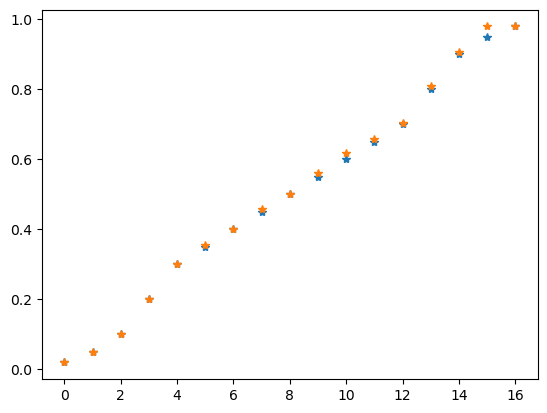

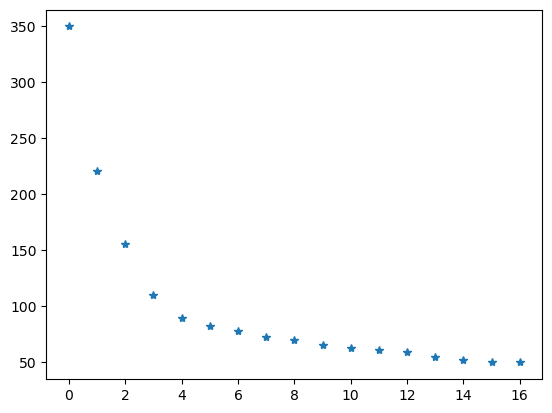

50

In [81]:
plt.figure()
plt.plot(density_approx,'*')
plt.plot(density,'*')

sizes = []
for i, d in enumerate(density_approx):
        size = int(np.sqrt(number_of_particles / d))
        sizes.append(size)
        
plt.figure()
plt.plot(sizes,'*')
plt.show()
sizes[-1]

In [82]:
print(f'T length: {len(T)} , density length: {len(density)}')


T length: 30 , density length: 17


In [83]:
size = 50          
number_of_particles = 0.99 * size**2


num_ones = int(number_of_particles)
num_zeros = size * size - num_ones

lattice = np.concatenate((np.ones(num_ones, dtype=int), np.zeros(num_zeros, dtype=int)),axis=0)

# Shuffle the array to distribute 1s and 0s randomly
np.random.shuffle(lattice)

# Reshape the 1D array into a 2D lattice
lattice = lattice.reshape(size, size)

pos1 = np.where(lattice == 1)
pos1 = np.array(pos1)           # coordinates of 1's

pos0 = np.where(lattice == 0)   
pos0 = np.array(pos0)           # coordinates of 0's

density = number_of_particles/size**2

In [84]:
pos0

array([[ 4,  7,  9, 15, 16, 17, 17, 17, 21, 21, 24, 28, 31, 32, 35, 37,
        37, 38, 40, 40, 42, 43, 44, 46, 48],
       [36,  9,  5, 35, 14,  5, 15, 17,  2, 15, 49, 22, 19, 34, 11,  7,
        27, 28, 30, 40, 40, 10,  1, 48, 38]])

In [88]:
def energy_history_plot(T, E_history, size, ratio, num_runs):
    yMin = min(E_history[len(T)-1])-4
    yMax = max(E_history[0])

    # Create subplots
    fig, axes = plt.subplots(len(T), 1, figsize=(8, 2*len(T)))
    fig.suptitle(f'{size} by {size}, density={ratio}')

    for i in range(len(T)):
        ax = axes[i]

        T_formatted = f'{T[i]:.2f}'
        ax.plot(np.arange(0, num_runs), E_history[i], '.', markersize = '1')
        ax.set_yticks(np.arange(yMin, yMax, step = 20))
        ax.set_ylabel(f'Energy (T = {T_formatted})')
        #ax.set_xlabel('Iteration')
        #ax.set_title()

    #plt.tight_layout()
    #plt.savefig('Runs_data/1e6_100x100.svg', format ='svg')
    plt.show()

#d = 0
energy_history_plot(T, E_history[0], size, density[0], num_runs)

TypeError: 'float' object is not subscriptable

In [55]:
E_history[0]
density

0.99

## Save data

In [165]:
# SAVE DATA 

current_dir = os.getcwd()

# directory of Data folder
new_dir = f'{current_dir}/Data/'

# Save data there
file_spec = 'run10000'
file_name = f'{run_name}_{file_spec}.npz'
file_dir = f'{new_dir}{file_name}'

np.savez(file_dir, T = T, density = density, E_mean = E_mean, E_variance=E_var, num_runs = num_runs, MinLatticeSize = size_mini, eps=eps, execution_time=execution_time )



In [ ]:
# TRY AND LOAD FILE AGAIN

npzfile = np.load(file_dir)

npzfile.files

lala = npzfile['T']


array([4, 3, 2])